In [ ]:
from copy import deepcopy

import numpy as np
from numpy import asarray, sqrt, eye, abs as npabs, kron, pi, ndarray, append
from matplotlib.pyplot import subplots, show

from pytreenet.core import Node
from pytreenet.ttns import TreeTensorNetworkState
from pytreenet.operators import TensorProduct, Hamiltonian, pauli_matrices
from pytreenet.ttno import TreeTensorNetworkOperator

from pytreenet.time_evolution.bug import BUG
from pytreenet.time_evolution.exact_time_evolution import ExactTimeEvolution
from pytreenet.time_evolution.ttn_time_evolution import TTNTimeEvolutionConfig
from pytreenet.util.tensor_splitting import SVDParameters

## Two Qubits

The SWAP-Gate can be obtained from:
$$
\text{SWAP} = e^{-i \frac{\pi}{4} (X_1 X_2 + Y_1 Y_2 + Z_1 Z_2 + I_1 I_2)}
$$
We will use the initial state $\ket{0} \otimes \ket{1}$, so we can clearly observe the swapping.

In [ ]:
time_step_size = 0.01
final_time = 2*3.2

In [5]:
dim = 2
init_state_0 = asarray([1.0, 0.0], dtype=complex)
init_state_0 = init_state_0.reshape(1, dim)
init_state_1 = asarray([0.0, 1.0], dtype=complex)
init_state_1 = init_state_1.reshape(1, dim)

qubit0_id = "Qubit0"
node_0 = Node(identifier=qubit0_id)
qubit1_id = "Qubit1"
node_1 = Node(identifier=qubit1_id)

tq_ttns = TreeTensorNetworkState()
tq_ttns.add_root(node_0, init_state_0)
tq_ttns.add_child_to_parent(node_1, init_state_1, 0, qubit0_id, 0)

In [6]:
X, Y, Z = pauli_matrices()
identity = eye(dim)

Generate SWAP-Hamiltonian

In [8]:
swap_terms = [
    TensorProduct({qubit0_id: "X", qubit1_id: "X"}),
    TensorProduct({qubit0_id: "Y", qubit1_id: "Y"}),
    TensorProduct({qubit0_id: "Z", qubit1_id: "Z"}),
    TensorProduct({qubit0_id: "I2", qubit1_id: "I2"}),
]

conversion_dict = {"X": X, "Y": Y, "Z": Z, "I2": identity}
swap_hamiltonian = Hamiltonian(
    swap_terms,
    conversion_dictionary=conversion_dict,
)
tq_ttno = TreeTensorNetworkOperator.from_hamiltonian(swap_hamiltonian, tq_ttns)

In [9]:
tq_ops = {
    qubit0_id: TensorProduct({qubit0_id: pauli_matrices()[2]}),
    qubit1_id: TensorProduct({qubit1_id: pauli_matrices()[2]}),
}

Simulation

In [ ]:
config = TTNTimeEvolutionConfig(record_bond_dim=True)
tq_bug = BUG(tq_ttns, tq_ttno, time_step_size, final_time, tq_ops, config=config)

In [ ]:
tq_bug.run()

### Exact Simulation

In [30]:
tq_ref_state = kron(
    asarray([1.0, 0.0], dtype=complex), asarray([0.0, 1.0], dtype=complex)
)
swap_ref_ham = (
    kron(pauli_matrices()[0], pauli_matrices()[0])
    + kron(pauli_matrices()[1], pauli_matrices()[1])
    + kron(pauli_matrices()[2], pauli_matrices()[2])
    + kron(eye(dim), eye(dim))
)
tq_ref_ops = {
    qubit1_id: kron(eye(dim), pauli_matrices()[2]),
    qubit0_id: kron(pauli_matrices()[2], eye(dim)),
}
tq_exact = ExactTimeEvolution(
    tq_ref_state, swap_ref_ham, time_step_size, final_time, tq_ref_ops
)

In [31]:
tq_exact.run()

100%|██████████| 641/641 [00:00<00:00, 90095.80it/s]


### Evaluating and Plotting

In [32]:
times = tq_exact.times()

In [ ]:
print("Sanity Check: ", tq_bug.results_real())
tq_results0 = tq_bug.operator_result(qubit0_id, realise=True)
tq_results1 = tq_bug.operator_result(qubit1_id, realise=True)
tq_exact_results0 = tq_exact.operator_result(qubit0_id, realise=True)
tq_exact_results1 = tq_exact.operator_result(qubit1_id, realise=True)
tq_error0 = npabs(tq_results0 - tq_exact_results0)
tq_error1 = npabs(tq_results1 - tq_exact_results1)

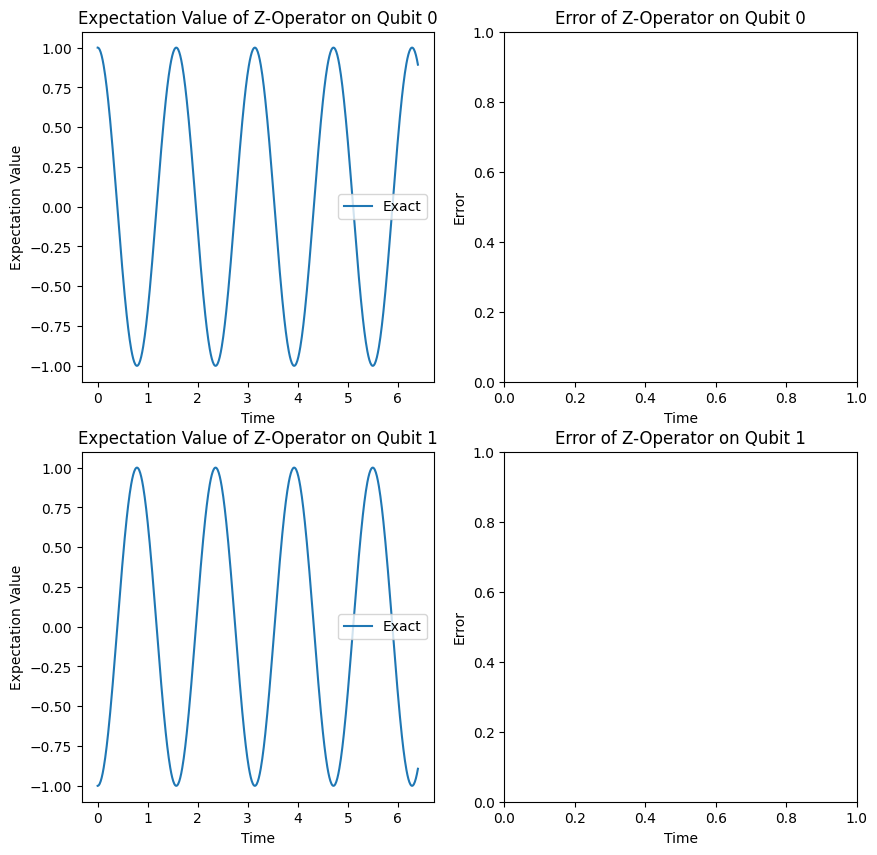

In [ ]:
fig, axs = subplots(2,2, figsize=(10, 10))

axs[0,0].plot(times, tq_results0, label="BUG")
axs[0,0].plot(times, tq_exact_results0, label="Exact")
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("Expectation Value")
axs[0,0].set_title("Expectation Value of Z-Operator on Qubit 0")
axs[0,0].legend()

axs[1,0].plot(times, tq_results1, label="BUG")
axs[1,0].plot(times, tq_exact_results1, label="Exact")
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Expectation Value")
axs[1,0].set_title("Expectation Value of Z-Operator on Qubit 1")
axs[1,0].legend()

axs[0,1].semilogy(times, tq_error0)
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Error")
axs[0,1].set_title("Error of Z-Operator on Qubit 0")

axs[1,1].semilogy(times, tq_error1)
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Error")
axs[1,1].set_title("Error of Z-Operator on Qubit 1")

show()